In [1]:
import os, sys, re
import numpy as np
import datetime
from pprint import pprint

file_pattern = r'req[0-9]{4}\.log'

files = sorted([f for f in os.listdir(os.getcwd()) if re.match(file_pattern, f)])

In [2]:
keys = ['200', '404', '500']
count = {}
errors = {}
for k in keys:
    count[k] = 0
    errors[k] = []
times = []
no_match = 0
article_list = []
articles = {}
    
for f in files:
    with open(f, mode='r', encoding='utf-8') as log:
        for line in log:
            match = re.search(r'\[(?P<article>.*)\]:\s+(?P<code>\d+)\s+(?P<duration>.*)', line)
            if match:
                match = match.groupdict()
            else:
                continue
            count[match['code']] += 1
            if match['code'] != '200':
                errors[match['code']].append(match['article'])
            duration = re.search(r'(?P<hours>[0-9]):(?P<minutes>[0-9]+):(?P<seconds>[0-9]+)\.(?P<mseconds>[0-9]+)', match['duration']).groupdict()
            dur = datetime.timedelta(hours=int(duration['hours']), minutes=int(duration['minutes']), seconds=int(duration['seconds']), microseconds=int(duration['mseconds'])).total_seconds()
            if dur > 0.1:  # ignore cached results
                times.append(dur)
                article_list.append(match['article'])
            articles[match['article']] = {
                'code': match['code'],
                'duration': int(dur)
            }
count['all'] = sum([count[k] for k in keys])
time = {
    'total': int(sum(times)),
    'average': int(np.mean(times)),
    'median': int(np.median(times)),
    'max': [int(i) for i in sorted(times, reverse=True)],
    'min': [int(i) for i in sorted(times) if int(i) > 58]  # shorter than 58 seconds => error
}

In [3]:
# because of fail
count['all'] += 4551
count['200'] += 4065
count['404'] += 288
count['500'] += 198
time['total'] += 1056060

In [4]:
print("""
Total articles:  {:10}
Success:         {:10}  =>  Rate: {:5.2f}%
Error:           {:10}  =>  Rate: {:5.2f}%
    404:         {:10}  =>  Rate: {:5.2f}%  =>  from Errors: {:5.2f}%
    500:         {:10}  =>  Rate: {:5.2f}%  =>  from Errors: {:5.2f}%

Total time:      {}
Average:         {}
Median:          {}
Max:             {}, {}, {}, {}, {}
Min:             {}, {}, {}, {}, {}
""".format(
        count['all'],
        count['200'],
        (count['200'] / count['all']) * 100,
        count['404'] + count['500'],
        ((count['404'] + count['500']) / count['all']) * 100,
        count['404'],
        (count['404'] / count['all']) * 100,
        (count['404'] / (count['404'] + count['500'])) * 100,
        count['500'],
        (count['500'] / count['all']) * 100,
        (count['500'] / (count['404'] + count['500'])) * 100,
        
        "{:2}d {:02}h {:02}m {:02}s".format(time['total'] // 86400, (time['total'] % 86400) // 3600, (time['total'] % 3600) // 60, (time['total'] % 3600) % 60),
        "    {:02}h {:02}m {:02}s".format(time['average'] // 3600, (time['average'] % 3600) // 60, (time['average'] % 3600) % 60),
        "    {:02}h {:02}m {:02}s".format(time['median'] // 3600, (time['median'] % 3600) // 60, (time['median'] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['max'][0] // 3600, (time['max'][0] % 3600) // 60, (time['max'][0] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['max'][1] // 3600, (time['max'][1] % 3600) // 60, (time['max'][1] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['max'][2] // 3600, (time['max'][2] % 3600) // 60, (time['max'][2] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['max'][3] // 3600, (time['max'][3] % 3600) // 60, (time['max'][3] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['max'][4] // 3600, (time['max'][4] % 3600) // 60, (time['max'][4] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['min'][0] // 3600, (time['min'][0] % 3600) // 60, (time['min'][0] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['min'][1] // 3600, (time['min'][1] % 3600) // 60, (time['min'][1] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['min'][2] // 3600, (time['min'][2] % 3600) // 60, (time['min'][2] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['min'][3] // 3600, (time['min'][3] % 3600) // 60, (time['min'][3] % 3600) % 60),
        "{:2}h {:02}m {:02}s".format(time['min'][4] // 3600, (time['min'][4] % 3600) // 60, (time['min'][4] % 3600) % 60),
    ))


Total articles:       13402
Success:              11862  =>  Rate: 88.51%
Error:                 1540  =>  Rate: 11.49%
    404:               1237  =>  Rate:  9.23%  =>  from Errors: 80.32%
    500:                303  =>  Rate:  2.26%  =>  from Errors: 19.68%

Total time:      28d 20h 55m 35s
Average:             00h 02m 43s
Median:              00h 01m 12s
Max:              9h 39m 30s,  9h 10m 08s,  8h 15m 57s,  8h 14m 27s,  7h 29m 58s
Min:              0h 00m 59s,  0h 00m 59s,  0h 00m 59s,  0h 00m 59s,  0h 00m 59s



In [5]:
long_duration = []
for (idx, t) in enumerate(times):
    if t > 60*45:  # more than 3/4 hour
        long_duration.append("{:2}h {:02}m {:02}s for '{}'".format(int(t) // 3600, (int(t) % 3600) // 60, (int(t) % 3600) % 60, article_list[idx]))
pprint(sorted(long_duration, reverse=True))

[" 9h 39m 30s for 'List of historical countries and empires spanning more "
 "than one continent'",
 " 9h 10m 08s for '1922 in poetry'",
 " 8h 15m 57s for 'List of mammals in Argentina'",
 " 8h 14m 27s for 'List of years in poetry'",
 " 7h 29m 58s for 'Bonkers 7: Millennium Fever'",
 " 7h 19m 09s for 'Okiayu Ryootaroo'",
 " 6h 43m 55s for 'Guy Beart'",
 " 6h 27m 51s for 'Okiayu Ryotaro'",
 " 6h 11m 16s for 'Meshed'",
 " 5h 49m 20s for 'Look at Me I'm Three'",
 " 5h 25m 04s for 'MLB on FOX Commentators'",
 " 5h 08m 38s for 'Tracks (Springsteen)'",
 " 4h 46m 14s for 'SACUA'",
 " 4h 38m 49s for 'War-gods'",
 " 3h 43m 04s for 'The Highlight Reel'",
 " 3h 42m 00s for 'The Davenport Family'",
 " 3h 34m 47s for 'Hugh Hopper'",
 " 3h 24m 45s for 'List of ESPN MLB Broadcast Teams'",
 " 3h 16m 45s for 'List of Chinese battles'",
 " 2h 48m 39s for 'Best-selling albums in the United States since Nielsen "
 "SoundScan tracking began'",
 " 2h 36m 45s for 'Abd-El-Kadir'",
 " 2h 36m 09s for 'Tommy Mur

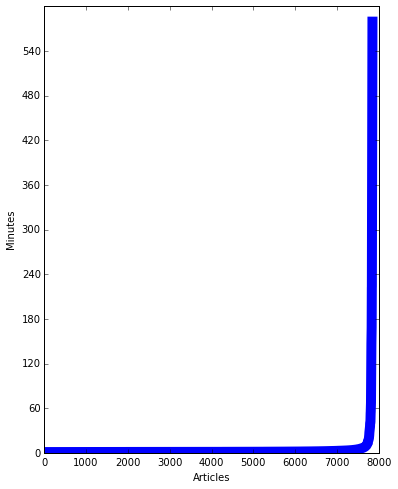

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(6,8))
ax.plot([t / 60 for t in time['min']], color='blue', lw=10)
ax.set_yticks(range(0, 600, 60))
ax.set_ylabel('Minutes')
ax.set_xlabel('Articles')

plt.savefig('duration.png')
plt.show()

In [7]:
print("""
Time spend in errors:  {:3.2f}h
    404:               {:3.2f}h
    500:               {:3.2f}h
""".format(
        sum(t['duration'] for (_, t) in articles.items() if t['code'] in ['404', '500']) / 3600,
        sum(t['duration'] for (_, t) in articles.items() if t['code'] == '404') / 3600,
        sum(t['duration'] for (_, t) in articles.items() if t['code'] == '500') / 3600,
    )
)


Time spend in errors:  80.69h
    404:               0.07h
    500:               80.62h



In [19]:
durations = [1, 2, 3, 5, 10, 15, 20, 30, 45, 60, 90, 120, 180, 240, 300]
print("""| longer (min) |   total  |  success |   error  |
|-----------------------------------------------|""")
for d in durations:
    print("""|          {:3} |   {:6} |   {:6} |   {:6} |""".format(
            d,
            sum(1 if t['duration'] > 60*d else 0 for (_, t) in articles.items()),
            sum(1 if t['duration'] > 60*d and t['code'] == '200' else 0 for (_, t) in articles.items()),
            sum(1 if t['duration'] > 60*d and t['code'] != '200' else 0 for (_, t) in articles.items()))
    )

| longer (min) |   total  |  success |   error  |
|-----------------------------------------------|
|            1 |     7721 |     7631 |       90 |
|            2 |     1295 |     1244 |       51 |
|            3 |      665 |      636 |       29 |
|            5 |      326 |      302 |       24 |
|           10 |      146 |      123 |       23 |
|           15 |      106 |       83 |       23 |
|           20 |       84 |       62 |       22 |
|           30 |       68 |       48 |       20 |
|           45 |       48 |       34 |       14 |
|           60 |       37 |       24 |       13 |
|           90 |       32 |       20 |       12 |
|          120 |       29 |       18 |       11 |
|          180 |       19 |       10 |        9 |
|          240 |       14 |        6 |        8 |
|          300 |       12 |        4 |        8 |


In [21]:
print("Success articles with time over 120 minutes")
for a, t in sorted([(a_name, t['duration']) for (a_name, t) in articles.items() if t['duration'] > 60*120 and t['code'] == '200'], reverse=True, key=lambda x: x[1]):
    print("{}: {:2}h {:02}m".format(a, t // 3600, (t % 3600) // 60))

Success articles with time over 120 minutes
Okiayu Ryootaroo:  7h 19m
Okiayu Ryotaro:  6h 27m
Look at Me I'm Three:  5h 49m
Tracks (Springsteen):  5h 08m
SACUA:  4h 46m
War-gods:  4h 38m
The Highlight Reel:  3h 43m
The Davenport Family:  3h 42m
Hugh Hopper:  3h 34m
List of ESPN MLB Broadcast Teams:  3h 24m
Best-selling albums in the United States since Nielsen SoundScan tracking began:  2h 48m
Abd-El-Kadir:  2h 36m
ESPN MLB Broadcast Teams:  2h 33m
Abd-El-Kader:  2h 32m
2007 Tampa Bay Storm season:  2h 30m
List of mammals in Bolivia:  2h 26m
Spirou (magazine):  2h 14m
Jazz waltz:  2h 06m


In [22]:
print("Failed articles with time over 120 minutes")
for a, t in sorted([(a_name, t['duration']) for (a_name, t) in articles.items() if t['duration'] > 60*120 and t['code'] != '200'], reverse=True, key=lambda x: x[1]):
    print("{}: {:2}h {:02}m".format(a, t // 3600, (t % 3600) // 60))

Failed articles with time over 120 minutes
List of historical countries and empires spanning more than one continent:  9h 39m
1922 in poetry:  9h 10m
List of mammals in Argentina:  8h 15m
List of years in poetry:  8h 14m
Bonkers 7: Millennium Fever:  7h 29m
Guy Beart:  6h 43m
Meshed:  6h 11m
MLB on FOX Commentators:  5h 25m
List of Chinese battles:  3h 16m
Tommy Murphy (soccer player):  2h 36m
Hookman:  2h 14m


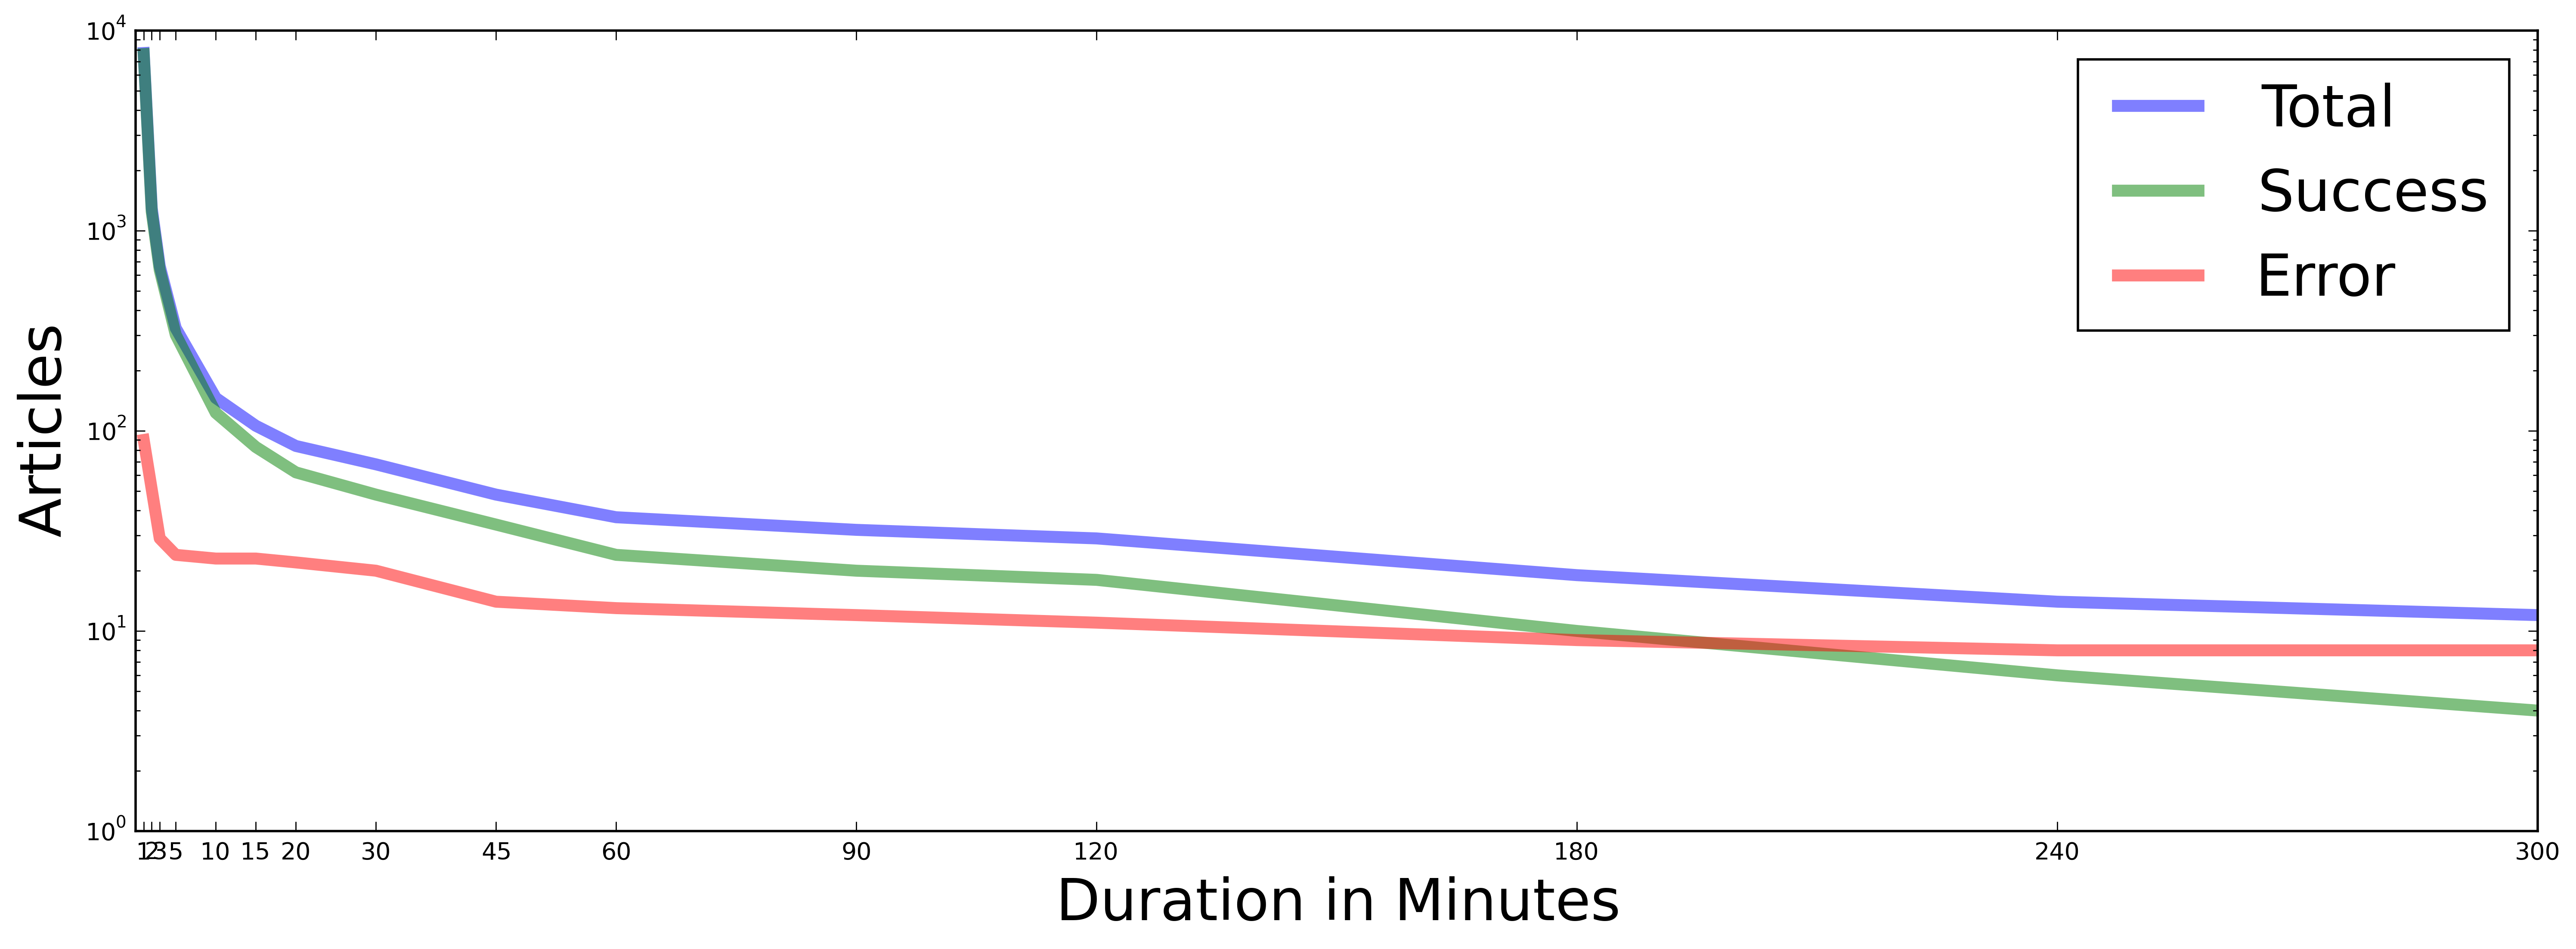

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rc('savefig', dpi=400)
plt.rc('legend', fontsize=24)

fig, ax = plt.subplots(figsize=(18,6))

ax.plot(durations, [sum(1 if t['duration'] > 60*d else 0 for (_, t) in articles.items()) for d in durations], color='blue', lw=5, label='Total', alpha=.5)
ax.plot(durations, [sum(1 if t['duration'] > 60*d and t['code'] == '200' else 0 for (_, t) in articles.items()) for d in durations], color='green', lw=5, label='Success', alpha=.5)
ax.plot(durations, [sum(1 if t['duration'] > 60*d and t['code'] != '200' else 0 for (_, t) in articles.items()) for d in durations], color='red', lw=5, label='Error', alpha=.5)

ax.set_xticks(durations)

ax.set_ylabel('Articles', fontsize=24)
ax.set_xlabel('Duration in Minutes', fontsize=24)

#ax.set_xscale('log')
ax.set_yscale('log')

ax.legend()

plt.savefig('success-over-time.png', bbox_inches='tight')
plt.show('success-over-time.png')